In [1]:
import cv2
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import scipy
import scipy.sparse
import scipy.sparse.linalg

In [3]:
img_gray = cv2.imread('pic/Lenna_grayscale.bmp')
img_color = cv2.imread('pic/Lenna_color.bmp')
img_color =img_color[:,:,::-1]

In [4]:
gray_yuv = cv2.cvtColor(img_gray, cv2.COLOR_BGR2YUV)
gray_y, gray_u, gray_v = cv2.split(gray_yuv)

color_yuv = cv2.cvtColor(img_color, cv2.COLOR_BGR2YUV)
color_y, color_u, color_v = cv2.split(color_yuv)

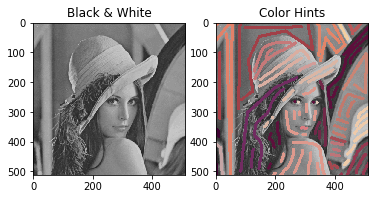

In [5]:
fig = plt.figure()
fig.add_subplot(1,2,1).set_title('Black & White')
imgplot = plt.imshow(img_gray)
fig.add_subplot(1,2,2).set_title('Color Hints')
imgplot = plt.imshow(img_color)
plt.show()

In [6]:
(rows,cols,_) = img_gray.shape
pic_size = rows*cols

color_point = (color_u - gray_u) > 1e-5


In [7]:
class find_neighbor:
    def __init__(self,center, pic_y):
        self.center = center
        self.pic_y = pic_y
        self.width = 1
        self.neighbors = []
        self.mean = None
        self.var = None
        self.findneighbors()
        # self.y = [r,c, y]
        self.neighbors = np.array(self.neighbors).astype(float)
        self.cal_weight()
        
    def findneighbors(self):
        r_start = max(0, self.center[0]-self.width)
        r_end = min(self.pic_y.shape[0],self.center[0] + self.width +1)
        c_start = max(0, self.center[1]-self.width)
        c_end = min(self.pic_y.shape[1],self.center[1] + self.width +1)
        for r in range(r_start, r_end):
            for c in range(c_start, c_end):
                if r == self.center[0] and c == self.center[1]:
                    continue
                self.neighbors.append([int(r),int(c),self.pic_y[r,c]])
                
    def cal_weight(self):
        diff = self.neighbors[:,2] - self.pic_y[self.center]
        self.var = np.var(diff)
        if self.var<1e-6:
            self.var = 1e-6
        if all(diff== np.mean(diff)) :
            w_ = [-1/len(diff) for i in range(len(diff))]
        else:
            w = np.exp(- np.power(diff,2) / (self.var* 2.0))
            if np.sum(w)==0:
                w_ = [-1/len(diff) for i in range(len(diff))]
            else:
                w_ = - w / np.sum(w)
        self.neighbors[:,2] = w_
        '''
        if self.center[0]==self.center[1]:
            print("=====diff")
            print(diff)
            print("=====w")
            print(w)
            print("=====w_")
            print(w_)
        '''
        

In [8]:
weight =[]
b_u = np.zeros(pic_size)
b_v = np.zeros(pic_size)

for r in range(rows):
    for c in range(cols):
        if not color_point[r,c]:
            w= find_neighbor((r,c),gray_y)
            for e in w.neighbors:
                weight.append([r*cols+c,e[0]*cols+e[1],e[2]])
        else:
            b_u[r*cols+c] = color_u[r,c]
            b_v[r*cols+c] = color_v[r,c]
        weight.append([r*cols+c,r*cols+c,1.]) 
            
weight = np.array(weight)

matA = scipy.sparse.csr_matrix((weight[:,2], (weight[:,0], weight[:,1])), shape=(pic_size, pic_size))

In [9]:
print('Optimizing Ax=b')
ansU = scipy.sparse.linalg.spsolve(matA, b_u)
ansV = scipy.sparse.linalg.spsolve(matA, b_v)

ansU = ansU.reshape(rows,cols)
ansV = ansV.reshape(rows,cols)

ans_yuv = np.dstack((gray_y,ansU,ansV)).astype(np.uint8)

Optimizing Ax=b


Optimized Ax=b


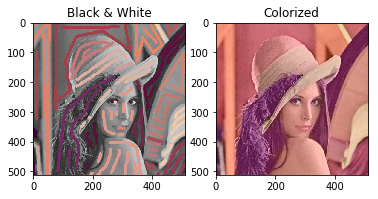

In [10]:
ans_rgb=cv2.cvtColor(ans_yuv,cv2.COLOR_YUV2BGR)
print('Optimized Ax=b')

fig = plt.figure()
fig.add_subplot(1,2,1).set_title('Black & White')
imgplot = plt.imshow(img_color)
fig.add_subplot(1,2,2).set_title('Colorized')
imgplot = plt.imshow(ans_rgb)
plt.show();